In [1]:
import os


import pandas as pd
import numpy as np
# import sklearn

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


from cal_feature import *
from plot_transient import *
from plot_feature1 import *
from plot_feature2 import *
from myMedFilter import *
from myHeatMap import *
from myScatter import *
from linearRegression import *

In [2]:
# define local directions
file_forder = "./transient_timeDomain/" 
up_dir = "./up_edge/"
down_dir = "./down_edge/"
up_pic_dir = "./up_edge_pic/"
down_pic_dir = "./down_edge_pic/"
feature_pic_dir = "./feature_pic/"
# save flag
SAVE_TRANSIENT = True
SAVE_SAMPLE = True
# plot flag
PLOT_TRANSIENT = False
PLOT_FEATURE = False
# feature flag
PRE_SLICE = 30
DUR_SLICE = 1024
DUR_SLICE_UP = 1024
SUB_SAMPLE = 1
NUM_MEAN = 15
DROP_OUTLIERS = True
CORR_TRESH1 = 0.99
CORR_TRESH2 = 0.6
# train flag
NUM_SPLIT = 370
BATCH_SIZE = 344
NUM_HIDEN1 = 100
NUM_HIDEN2 = 32
DROPOUT = 0.5
NUM_EPOCH = 30000
# proceed flag
IS_SLICE = not True
IS_EXPAND = not True
IS_TRAIN = True
IS_FEATURE = True
# debug mode
DEBUG_MODE = False
# raw RNN
RAW_RNN = True

# slice data while switching 
### 1. up-edge 
### 2. down-edge

In [3]:
# slice data
if IS_SLICE:
    if DEBUG_MODE:
        SAVE_TRANSIENT = False
        PLOT_TRANSIENT = True
        PRE_SLICE = 30
        DUR_SLICE = 512

    for (_ ,_ , process_files) in os.walk(file_forder):
        for file in process_files:
            sample_df = pd.read_csv(file_forder + file )
            sample_name = file[:-4]
            # get index in up and down edge
            n = np.where(sample_df.gateSignalVoltage.values>8)  # return a tuple so use n[0][0] to index
            # slice data
            up_df = sample_df.iloc[n[0][0]-PRE_SLICE:n[0][0]+DUR_SLICE_UP-PRE_SLICE,:]
            down_df = sample_df.iloc[n[0][-1]-PRE_SLICE:n[0][-1]+DUR_SLICE_UP-PRE_SLICE,:]
            # expand feature
            up_df = up_df.drop(["collectorEmitterCurrentSingal"],axis = 1)
            up_df["P"] = up_df["gateEmitterVoltage"]*up_df["collectorEmitterVoltage"]
            down_df = down_df.drop(["collectorEmitterCurrentSingal"],axis = 1)
            down_df["P"] = down_df["gateEmitterVoltage"]*down_df["collectorEmitterVoltage"]
            # save data
            if SAVE_TRANSIENT:
                up_df.to_csv(up_dir+file,index = False)
                down_df.to_csv(down_dir+file,index = False)
            # plot data
            if PLOT_TRANSIENT:
                plot_transient(down_df,sample_name, down_pic_dir)
                plot_transient(up_df,sample_name,up_pic_dir)

    # show info
    # print(sample_df.shape)
    # print(sample_df.columns)
    # sample_df.head()

# featuring

In [4]:
# define local directions
up_dir = "./up_edge/"
down_dir = "./down_edge/"
if DEBUG_MODE:
    SUB_SAMPLE = 8
    SAVE_SAMPLE = True
    NUM_MEAN = 20

if IS_FEATURE:
    all_feature_df = pd.DataFrame()
    for (_ ,_ , process_files) in os.walk(file_forder):
        for file in process_files:
            # read file
            sample_df = pd.read_csv(down_dir+file)
            df = sample_df["collectorEmitterVoltage"].to_frame().T.reset_index(drop = True)
#             df = pd.concat([sample_df["gateEmitterVoltage"].to_frame().T.reset_index(drop = True),df],axis = 1)
            df['round'] = int(file[0:-4])
            all_feature_df = pd.concat([all_feature_df,df], axis = 0)
            
all_feature_df.sort_values(by="round", ascending=True,inplace=True)            
all_feature_df.to_csv('./temp/raw_RNN_data.csv',index = False)
print(all_feature_df.shape)
all_feature_df.head()

(418, 1025)


,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,round
0,4.7500,4.75000,4.75000,4.6875,4.7500,4.75000,4.81250,5.00000,5.0000,5.0625,...,-0.0625,-0.12500,-0.12500,-0.06250,-0.06250,-0.06250,-0.18750,-0.125,-0.06250,1
0,2.1875,2.18750,2.03125,2.1875,2.1875,2.18750,2.34375,2.18750,2.1875,2.1875,...,3.7500,3.75000,3.75000,3.59375,3.90625,3.90625,3.90625,3.750,3.90625,2
0,2.1875,2.03125,2.03125,2.1875,2.1875,2.03125,2.03125,2.34375,2.1875,2.1875,...,3.7500,3.90625,3.75000,3.75000,3.90625,3.75000,3.75000,3.750,3.90625,3
0,2.1875,2.03125,2.18750,2.1875,1.8750,2.18750,2.03125,2.18750,2.1875,2.1875,...,3.7500,3.90625,3.90625,3.75000,3.75000,3.90625,3.90625,3.750,3.59375,4
0,2.2500,2.18750,2.12500,2.1250,2.1875,2.18750,2.18750,2.25000,2.3125,2.3125,...,3.9375,4.00000,3.93750,3.87500,3.87500,3.93750,3.87500,3.875,3.93750,5


### conband temperature

In [5]:
# add temperature
train_df = pd.read_csv('./temp/raw_RNN_data.csv')
tempareture_df = pd.read_csv("collectorEmitterVoltage_peak_temperature.csv")
train_df = pd.merge(train_df,tempareture_df, how="left",on = "round" )
# change the target num
train_df.rename(columns={"round":"num_cycle"},inplace = True)
train_df.drop('collectorEmitterVoltage_peak', axis = 1, inplace = True)
# save
train_df.sort_values(by="num_cycle", ascending=True,inplace=True)   
train_df.to_csv("./temp/train_feature_df_subsample.csv",index = False)

print(train_df.shape)
train_df.head()

(418, 1026)


,0,1,2,3,4,5,6,7,8,9,...,1016,1017,1018,1019,1020,1021,1022,1023,num_cycle,temperature
0,4.7500,4.75000,4.75000,4.6875,4.7500,4.75000,4.81250,5.00000,5.0000,5.0625,...,-0.12500,-0.12500,-0.06250,-0.06250,-0.06250,-0.18750,-0.125,-0.06250,1,47.211104
1,2.1875,2.18750,2.03125,2.1875,2.1875,2.18750,2.34375,2.18750,2.1875,2.1875,...,3.75000,3.75000,3.59375,3.90625,3.90625,3.90625,3.750,3.90625,2,124.804264
2,2.1875,2.03125,2.03125,2.1875,2.1875,2.03125,2.03125,2.34375,2.1875,2.1875,...,3.90625,3.75000,3.75000,3.90625,3.75000,3.75000,3.750,3.90625,3,178.408544
3,2.1875,2.03125,2.18750,2.1875,1.8750,2.18750,2.03125,2.18750,2.1875,2.1875,...,3.90625,3.90625,3.75000,3.75000,3.90625,3.90625,3.750,3.59375,4,215.428544
4,2.2500,2.18750,2.12500,2.1250,2.1875,2.18750,2.18750,2.25000,2.3125,2.3125,...,4.00000,3.93750,3.87500,3.87500,3.93750,3.87500,3.875,3.93750,5,244.451166


# drop outliers

In [6]:
if DEBUG_MODE:
    PLOT_FEATURE = False
    DROP_OUTLIERS = True
# drop outl
round_num_del = [1,2,3,4,5,6,7,8,9,10,11,12,13,24,35,46,
#                  112,223,334,386,375,364,
#                  56,153,208,309,327,347,351,360,365,391
                ]

train_df = pd.read_csv('./temp/train_feature_df_subsample.csv')
if DROP_OUTLIERS:
    for num in round_num_del:
        train_df = train_df.loc[train_df['num_cycle'].values != num,:]
try:
    train_df = train_df.loc[train_df['temperature']>326,:]
except:
    train_df.rename(columns={"tempareture":"temperature"},inplace = True)
    train_df = train_df.loc[train_df['temperature']>326,:]
if PLOT_FEATURE:
    plot_feature1(train_df,"num_cycle",feature_pic_dir)
train_df.to_csv("./temp/train_feature_df_outliers_subsample.csv",index = False)

# show info
print(train_df.shape)
train_df.head()

(399, 1026)


,0,1,2,3,4,5,6,7,8,9,...,1016,1017,1018,1019,1020,1021,1022,1023,num_cycle,temperature
16,1.8750,1.8750,1.9375,1.8125,1.8125,1.8750,1.9375,1.9375,1.9375,2.0000,...,3.5000,3.5000,3.5000,3.5000,3.4375,3.5000,3.5000,3.5000,17,329.912613
17,1.9375,1.8750,1.8125,1.8750,1.8750,1.8750,1.8750,1.9375,1.9375,2.0000,...,3.5000,3.5625,3.5000,3.4375,3.5000,3.5000,3.4375,3.4375,18,327.237079
18,1.9375,2.0000,1.8750,1.8750,1.9375,1.9375,1.9375,2.0000,2.0000,2.1250,...,3.5625,3.5625,3.5625,3.5000,3.5625,3.5625,3.6250,3.5625,19,326.213509
19,1.8750,1.8750,1.8750,1.8750,1.8750,1.9375,2.0000,1.9375,2.0000,2.0625,...,3.4375,3.4375,3.4375,3.4375,3.4375,3.5000,3.4375,3.5000,20,329.365197
20,1.9375,1.9375,1.8750,1.8750,1.8750,1.8750,1.9375,1.9375,1.9375,1.9375,...,3.5625,3.5000,3.5625,3.5000,3.4375,3.5000,3.5000,3.5000,21,328.195866


### scale to [0, 1]

In [7]:
# std
train_df = pd.read_csv('./temp/train_feature_df_outliers_subsample.csv')
print(train_df.shape)
# drop_duplicates
target = ["temperature","num_cycle"]
cols = train_df.columns
cols_to_use = [c for c in cols if c not in target]
for col in cols_to_use:
    ma = 12
    mi = 0
    train_df[col] = (train_df[col]-mi)/(ma-mi)
    
train_df.to_csv("temp/train_df_scale_subsample.csv",index = False)
print(train_df.shape)
train_df.head()

(399, 1026)
(399, 1026)


,0,1,2,3,4,5,6,7,8,9,...,1016,1017,1018,1019,1020,1021,1022,1023,num_cycle,temperature
0,0.156250,0.156250,0.161458,0.151042,0.151042,0.156250,0.161458,0.161458,0.161458,0.166667,...,0.291667,0.291667,0.291667,0.291667,0.286458,0.291667,0.291667,0.291667,17,329.912613
1,0.161458,0.156250,0.151042,0.156250,0.156250,0.156250,0.156250,0.161458,0.161458,0.166667,...,0.291667,0.296875,0.291667,0.286458,0.291667,0.291667,0.286458,0.286458,18,327.237079
2,0.161458,0.166667,0.156250,0.156250,0.161458,0.161458,0.161458,0.166667,0.166667,0.177083,...,0.296875,0.296875,0.296875,0.291667,0.296875,0.296875,0.302083,0.296875,19,326.213509
3,0.156250,0.156250,0.156250,0.156250,0.156250,0.161458,0.166667,0.161458,0.166667,0.171875,...,0.286458,0.286458,0.286458,0.286458,0.286458,0.291667,0.286458,0.291667,20,329.365197
4,0.161458,0.161458,0.156250,0.156250,0.156250,0.156250,0.161458,0.161458,0.161458,0.161458,...,0.296875,0.291667,0.296875,0.291667,0.286458,0.291667,0.291667,0.291667,21,328.195866


## RNN

### prepare data

In [54]:
class myDataset_RNN(Dataset):
    def __init__(self, x_train, y_train, transpose = False,transform=None):
        self.x_train = x_train
        self.y_train = y_train
        self.transpose = transpose
        self.transform = transform
        self.size = x_train.shape[0]

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        if self.transpose:
            traindata = self.x_train[idx].transpose(0,1)  # use skitimage
        else:
            traindata = self.x_train[idx]   # use skitimage
        label = self.y_train[idx]

        sample = {'traindata': traindata, 'label': label}
        if self.transform:
            sample = self.transform(sample)

        return sample

In [55]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from myDataset_RNN import *

DEBUG_MODE = True
if DEBUG_MODE:
    NUM_SPLIT = 370
    BATCH_SIZE = 344
    DUR_SLICE =1024
    
train_df = pd.read_csv( "./temp/train_df_scale_subsample.csv")
train_df["temperature"] = (train_df["temperature"] - 326)*500/5.0
target = ["num_cycle","temperature"]
cols = train_df.columns
cols = [c for c in cols if c not in target]
num_input = len(cols)
# get data
x_train = train_df.loc[train_df['num_cycle'].values < NUM_SPLIT,cols].values
y_train = train_df.loc[train_df['num_cycle'].values < NUM_SPLIT,target].values/500.0
x_test = train_df.loc[train_df['num_cycle'].values > NUM_SPLIT-6,cols].values
y_test = train_df.loc[train_df['num_cycle'].values > NUM_SPLIT-6,target].values/500.0
x_train = [x_train[i:i+6] for i in range(x_train.shape[0]-6)]
y_train = [y_train[i+2] for i in range(y_train.shape[0]-6)]
x_test = [x_test[i:i+6] for i in range(x_test.shape[0]-6)]
y_test = [y_test[i+2] for i in range(y_test.shape[0]-6)]
# astype
x_train = torch.tensor(x_train,dtype = torch.float32 )
y_train = torch.tensor(y_train,dtype = torch.float32)
# y_train = y_train.unsqueeze_(1)
x_test = torch.tensor(x_test,dtype = torch.float32 )
y_test = torch.tensor(y_test,dtype = torch.float32)
# y_test = y_test.unsqueeze_(1)
# split

print("train data size",x_train.shape)
print("train label size",y_train.shape)
print("test data size",x_test.shape)
print("test label size",y_test.shape)


train_set = myDataset_RNN(x_train,y_train,True)
test_set = myDataset_RNN(x_test,y_test,True)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=54, shuffle=False)

train data size torch.Size([344, 6, 1024])
train label size torch.Size([344, 2])
test data size torch.Size([48, 6, 1024])
test label size torch.Size([48, 2])


In [56]:
for i,data in enumerate(train_loader):
    (X_batch, y_batch) = data["traindata"],data['label']
    print(X_batch.shape)
    print(X_batch.shape)
    break

torch.Size([344, 1024, 6])
torch.Size([344, 1024, 6])


### train 

In [28]:
class RNN1(nn.Module):
    def __init__(self,input_size = 1024, hidden_size = 64, num_layers = 1):
        super(RNN1, self).__init__( )

        self.rnn = nn.LSTM(         # if use nn.RNN(), it hardly learns
            input_size=input_size,
            hidden_size=hidden_size,         # rnn hidden unit
            num_layers=num_layers,           # number of rnn layer
            batch_first=True,       # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
            bidirectional = True
        )

        self.out = nn.Linear(hidden_size*2, 1)

    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        r_out, (h_n, h_c) = self.rnn(x, None)   # None represents zero initial hidden state

        # choose r_out at the last time step
        out = self.out(r_out[:, -1, :])
        return out

use gpu: True
step:[1000], train loss: 0.039968, test loss: 0.157426
step:[2000], train loss: 0.039435, test loss: 0.155751
step:[3000], train loss: 0.005751, test loss: 0.028976
step:[4000], train loss: 0.005434, test loss: 0.027008
step:[5000], train loss: 0.005148, test loss: 0.025026
step:[6000], train loss: 0.004942, test loss: 0.023556
step:[7000], train loss: 0.004849, test loss: 0.023993
step:[8000], train loss: 0.004736, test loss: 0.021256
step:[9000], train loss: 0.004719, test loss: 0.020287
step:[10000], train loss: 0.005297, test loss: 0.014966


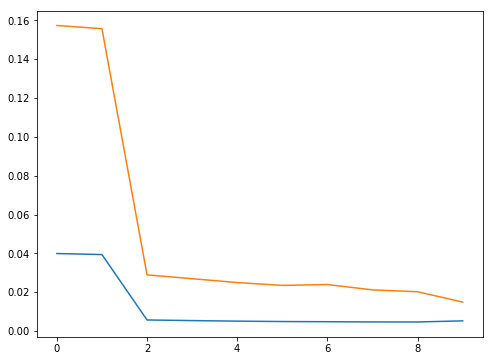

In [57]:
from weight_init import *
DEBUG_MODE = True

if DEBUG_MODE:
    DROPOUT = 0.5
    NUM_EPOCH = 10000
    DUR_SLICE = 1024
use_gpu = torch.cuda.is_available()
print("use gpu:",use_gpu)
model = RNN1(input_size = 6, hidden_size = 32, num_layers = 1 )
model.apply(weight_init)
try:
    model.load_state_dict(torch.load('./model/RNN1.pth'))
except:
    pass
if use_gpu:
    model = model.cuda()

# 定义loss和优化函数
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# 开始训练
losses_train  = []
losses_test = []


for epoch in range(NUM_EPOCH):
    model.train()
    for i,data in enumerate(train_loader):
        (X_batch, y_batch) = data["traindata"],data['label']
        if use_gpu:
            X_batch =X_batch.cuda()      
            y_batch =y_batch.cuda()
        n_pre = model(X_batch)
        loss = criterion(n_pre, y_batch[:,0].unsqueeze_(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    
    if (epoch+1) % 1000 == 0:
        model.eval()
        with torch.no_grad():
            for i,data in enumerate(test_loader):
                (X_batch, y_batch) = data["traindata"],data['label']
            if use_gpu:
                X_batch =X_batch.cuda()      
                y_batch =y_batch.cuda()
            n_pre = model(X_batch)
            loss_test = criterion(n_pre, y_batch[:,0].unsqueeze_(1))
        print(f'step:[{epoch+1}], train loss: {loss.item():.6f}, test loss: {loss_test.item():.6f}')
        losses_train.append(loss.item())
        losses_test.append(loss_test.item())

plt.figure(figsize = (8,6))
plt.plot(losses_train,label = "train loss")
plt.plot(losses_test,label = "teset loss")
plt.show()
torch.save(model.state_dict(), './model/RNN1.pth')

In [58]:
class RNN2(nn.Module):
    def __init__(self, in_dim, out_dim, n_feature1 = 8,n_feature2 = 8, droprate = 0.4):
        super(RNN2, self).__init__()
        self.conv1 = nn.Sequential(
            # nn.Conv1d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)
            nn.Conv2d(1, n_feature1, (1,16), stride=(2,8), padding=0), # (1024-16)/8+1 = 127 [*,8,2,127]
            nn.ReLU(True),
            )
        self.conv2 = nn.Sequential(
            # nn.Conv1d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)
            nn.Conv2d(n_feature1, n_feature2, (2,16), stride=(1,8), padding=(0,1)), # (127-16)/8+1 [*,8,2,15]
            nn.ReLU(True),
            )
        self.fc = nn.Sequential(
            nn.Linear(15*n_feature2*in_dim, out_dim),
#             nn.Dropout(p = droprate),
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

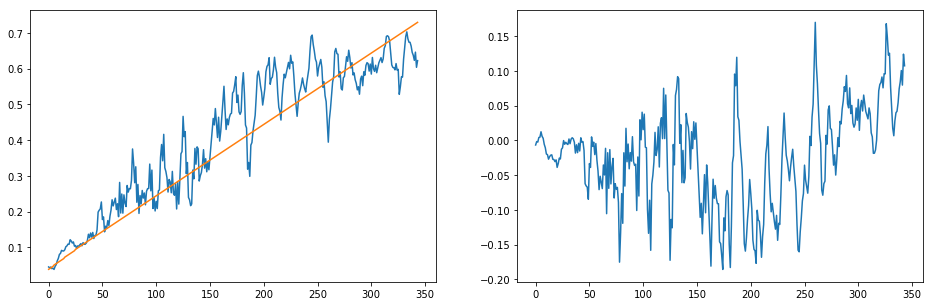

In [59]:
model.eval()
with torch.no_grad():
    for i,data in enumerate(train_loader):
        (X_batch, y_batch) = data["traindata"],data['label']
        if use_gpu:
            X_batch =X_batch.cuda()      
            y_batch =y_batch.cuda()
        predict = model(X_batch)
predict = predict.cpu()
y_batch =y_batch.cpu()
plt.close("all")
plt.figure(figsize=(16,5))
plt.subplot(121)
plt.plot(predict)
plt.plot(y_batch[:,0].unsqueeze_(1))
plt.subplot(122)
plt.plot((y_batch[:,0].unsqueeze_(1)-predict))
# a = train_df["temperature"].values
# plt.plot(a[:350]-0.5)
plt.show()

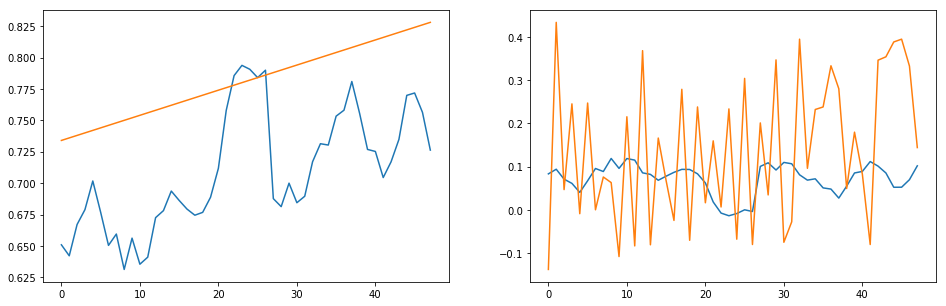

In [34]:
model.eval()
with torch.no_grad():
    for i,data in enumerate(test_loader):
        (X_batch, y_batch) = data["traindata"],data['label']
        if use_gpu:
            X_batch =X_batch.cuda()      
            y_batch =y_batch.cuda()
        predict = model(X_batch)
predict = predict.cpu()
y_batch =y_batch.cpu()
plt.close("all")
plt.figure(figsize=(16,5))
plt.subplot(121)
plt.plot(predict)
plt.plot(y_batch[:,0].unsqueeze_(1))
plt.subplot(122)
plt.plot((y_batch[:,0].unsqueeze_(1)-predict))
plt.plot(y_batch[:,1].unsqueeze_(1)-0.5)
plt.show()
